<a href="https://colab.research.google.com/github/aaron-v19/mlprojects/blob/main/Beatrice_wind_farm/Beatrice_ttm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Installation

In [2]:
# Clone the ibm/tsfm
! git clone https://github.com/IBM/tsfm.git

fatal: destination path 'tsfm' already exists and is not an empty directory.


In [3]:
# Change directory. Move inside the tsfm repo.
%cd tsfm

/content/tsfm


In [4]:
# Do ls
! ls

build		       LICENSE	 notebooks	 README.md  services  tsfmhfdemos  wiki.md
granite_tsfm.egg-info  Makefile  pyproject.toml  scripts    tests     tsfm_public


In [5]:
# Install the tsfm library
! pip install ".[notebooks]"

Processing /content/tsfm
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for granite-tsfm: filename=granite_tsfm-0.2.20-py3-none-any.whl size=2338040 sha256=1665f1fa5675c06366c6bca436679936d920583bdce5b51fa95088c76fcb016f
  Stored in directory: /tmp/pip-ephem-wheel-cache-06mlw7_8/wheels/b0/e9/d5/46ac6e5f659a03cfc8e396b992ac1b7e0c0bd1e34c7f5fe8e4
Successfully built granite-tsfm
  Attempting uninstall: granite-tsfm
    Found existing installation: granite-tsfm 0.2.20
    Uninstalling granite-tsfm-0.2.20:
      Successfully uninstalled granite-tsfm-0.2.20


Import Libraries

In [6]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd




# Local
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback

2025-02-13 04:00:40.420982: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739419240.717372    1831 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739419240.791014    1831 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 04:00:41.338829: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# First Party
from tsfm_public import count_parameters

from tsfm_public.toolkit.visualization import plot_predictions as plot_preds

#Important Arguments

In [8]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "beatrice"
DATA_ROOT_PATH = "/content/drive/MyDrive/Windmill project/Beatrice_data_main.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.05

#Get data

In [17]:
# Load the data file and see the columns
data = pd.read_csv(DATA_ROOT_PATH)
data['time'] = pd.to_datetime(data['time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
data

,time,u100,v100,fsr,Windspeed,Scaled_Windspeed_(at_90m),Wind_Direction,Power,year,month,precipitation (mm),rain (mm),pressure_msl (hPa)
0,1980-01-01 00:00:00,1.808975,-10.229706,0.000261,10.388420,10.150733,100.028260,378.95800,1980,1,0.0,0.0,1001.7
1,1980-01-01 01:00:00,1.916092,-10.346832,0.000242,10.522754,10.281994,100.491540,390.87520,1980,1,0.1,0.1,1001.1
2,1980-01-01 02:00:00,1.940201,-10.212601,0.000230,10.395267,10.157425,100.756920,379.56732,1980,1,0.0,0.0,1001.3
3,1980-01-01 03:00:00,2.296951,-10.099304,0.000224,10.357217,10.120245,102.813194,376.18005,1980,1,0.0,0.0,1000.8
4,1980-01-01 04:00:00,2.725143,-10.351501,0.000238,10.704205,10.459293,104.749070,406.82446,1980,1,0.1,0.1,1000.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
350383,2019-12-31 19:00:00,5.339706,5.910355,0.000109,7.965221,7.782983,227.903780,176.63489,2019,12,0.0,0.0,1029.5
350384,2019-12-31 20:00:00,5.571014,5.264069,0.000092,7.664634,7.489274,223.377300,156.59825,2019,12,0.0,0.0,1029.0
350385,2019-12-31 21:00:00,5.881805,5.061096,0.000089,7.759531,7.582000,220.710890,162.77127,2019,12,0.0,0.0,1028.7
350386,2019-12-31 22:00:00,5.934189,4.434921,0.000077,7.408314,7.238819,216.772630,140.61679,2019,12,0.0,0.0,1028.0


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350388 entries, 0 to 350387
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   time                       350388 non-null  datetime64[ns]
 1   u100                       350388 non-null  float64       
 2   v100                       350388 non-null  float64       
 3   fsr                        350388 non-null  float64       
 4   Windspeed                  350388 non-null  float64       
 5   Scaled_Windspeed_(at_90m)  350388 non-null  float64       
 6   Wind_Direction             350388 non-null  float64       
 7   Power                      350388 non-null  float64       
 8   year                       350388 non-null  int64         
 9   month                      350388 non-null  int64         
 10  precipitation (mm)         350388 non-null  float64       
 11  rain (mm)                  350388 non-null  float64 

<Axes: xlabel='time'>

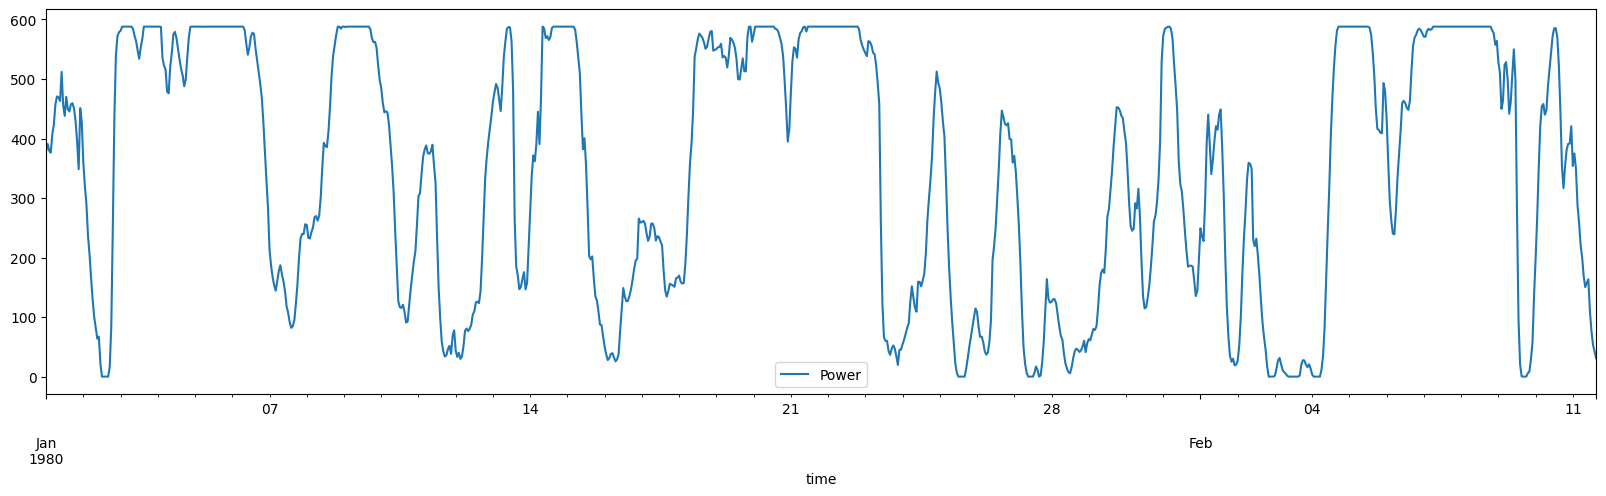

In [19]:
data.iloc[:1000].plot(x="time", y="Power", figsize=(20,5))

#Initial Cleaning


I used already cleaned data from data exploration notebook


# Data Processing Pipeline

In [20]:
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor

dataset_path = DATA_ROOT_PATH
timestamp_column = "time"
id_columns = []
target_columns = ['Power']
split_config = {
                "train": [0, 12 * 30 * 24 * 4],
                "valid": [12 * 30 * 24 * 4, 12 * 30 * 24 * 4 + 4 * 30 * 24 * 4],
                "test": [
                    12 * 30 * 24 * 4 + 4 * 30 * 24 * 4,
                    12 * 30 * 24 * 4 + 8 * 30 * 24 * 4,
                ],
            }
# Understanding the split config -- slides

#data = pd.read_csv(dataset_path,parse_dates=[timestamp_column],)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [
        'u100',
        'v100',
        'fsr',
        'Windspeed',
        'Scaled_Windspeed_(at_90m)',
        'Wind_Direction',
        'precipitation (mm)',
        'rain (mm)',
        'pressure_msl (hPa)'
    ],
}

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

train_dataset, valid_dataset, test_dataset = tsp.get_datasets(
    data, split_config, fewshot_fraction=fewshot_fraction, fewshot_location="first"
)
print(f"Data lengths: train = {len(train_dataset)}, val = {len(valid_dataset)}, test = {len(test_dataset)}")

Data lengths: train = 1607, val = 11425, test = 11425


/tmp/ipykernel_1831/2946659558.py:45: DeprecationWarning: Call to deprecated method get_datasets. (Please use the standalone function `get_datasets()`.) -- Deprecated since version 0.1.1.
  train_dataset, valid_dataset, test_dataset = tsp.get_datasets(


In [21]:
train_dataset[3]

{'past_values': tensor([[ 0.3144,  0.0357, -1.5742,  ..., -0.3255, -0.3188, -0.8543],
         [ 0.4511,  0.0959, -1.6076,  ...,  0.0100,  0.0248, -0.8463],
         [ 0.5265,  0.1225, -1.6277,  ..., -0.3255, -0.3188, -0.8543],
         ...,
         [ 1.2593, -3.0422, -0.3003,  ...,  1.0164,  1.0556, -1.8788],
         [ 1.2593, -3.0021, -0.4013,  ...,  1.0164,  1.0556, -1.8468],
         [ 1.2593, -3.2437, -0.1431,  ...,  1.3518,  1.3992, -1.8148]]),
 'future_values': tensor([[ 1.2593e+00, -3.1320e+00, -1.4574e-01,  9.7560e-01,  2.3135e+00,
           2.3135e+00,  1.7416e+00,  1.0164e+00,  1.0556e+00, -1.8708e+00],
         [ 1.2593e+00, -2.8724e+00, -2.9802e-01,  5.4475e-01,  1.9071e+00,
           1.9071e+00, -2.2479e+00,  2.6937e+00,  2.4300e+00, -1.8548e+00],
         [ 1.2593e+00, -2.7540e+00, -3.7700e-01,  3.3092e-01,  1.7281e+00,
           1.7281e+00, -2.2254e+00,  6.8091e-01,  7.1201e-01, -1.9109e+00],
         [ 1.2593e+00, -2.6686e+00, -4.7193e-01,  2.3529e-01,  1.6082e+00

#Zero-shot evaluation method

In [22]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION)
zeroshot_model

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

In [23]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=64,
    )
)

In [24]:
import wandb

wandb.login(key="30426370ccf0c5477118a427f0bed8eb18e5f832") # Replace YOUR_API_KEY
# Initialize wandb before evaluating
wandb.init(project="Beatrice_ttm", name="test run")  # Replace with your project and run names


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: aaronjosephvazhuthanapillil (aaronjosephvazhuthanapillil-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [25]:
zeroshot_trainer.evaluate(test_dataset)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


{'eval_loss': 0.9222576022148132,
 'eval_model_preparation_time': 0.0051,
 'eval_runtime': 5.7734,
 'eval_samples_per_second': 1978.888,
 'eval_steps_per_second': 31.004}

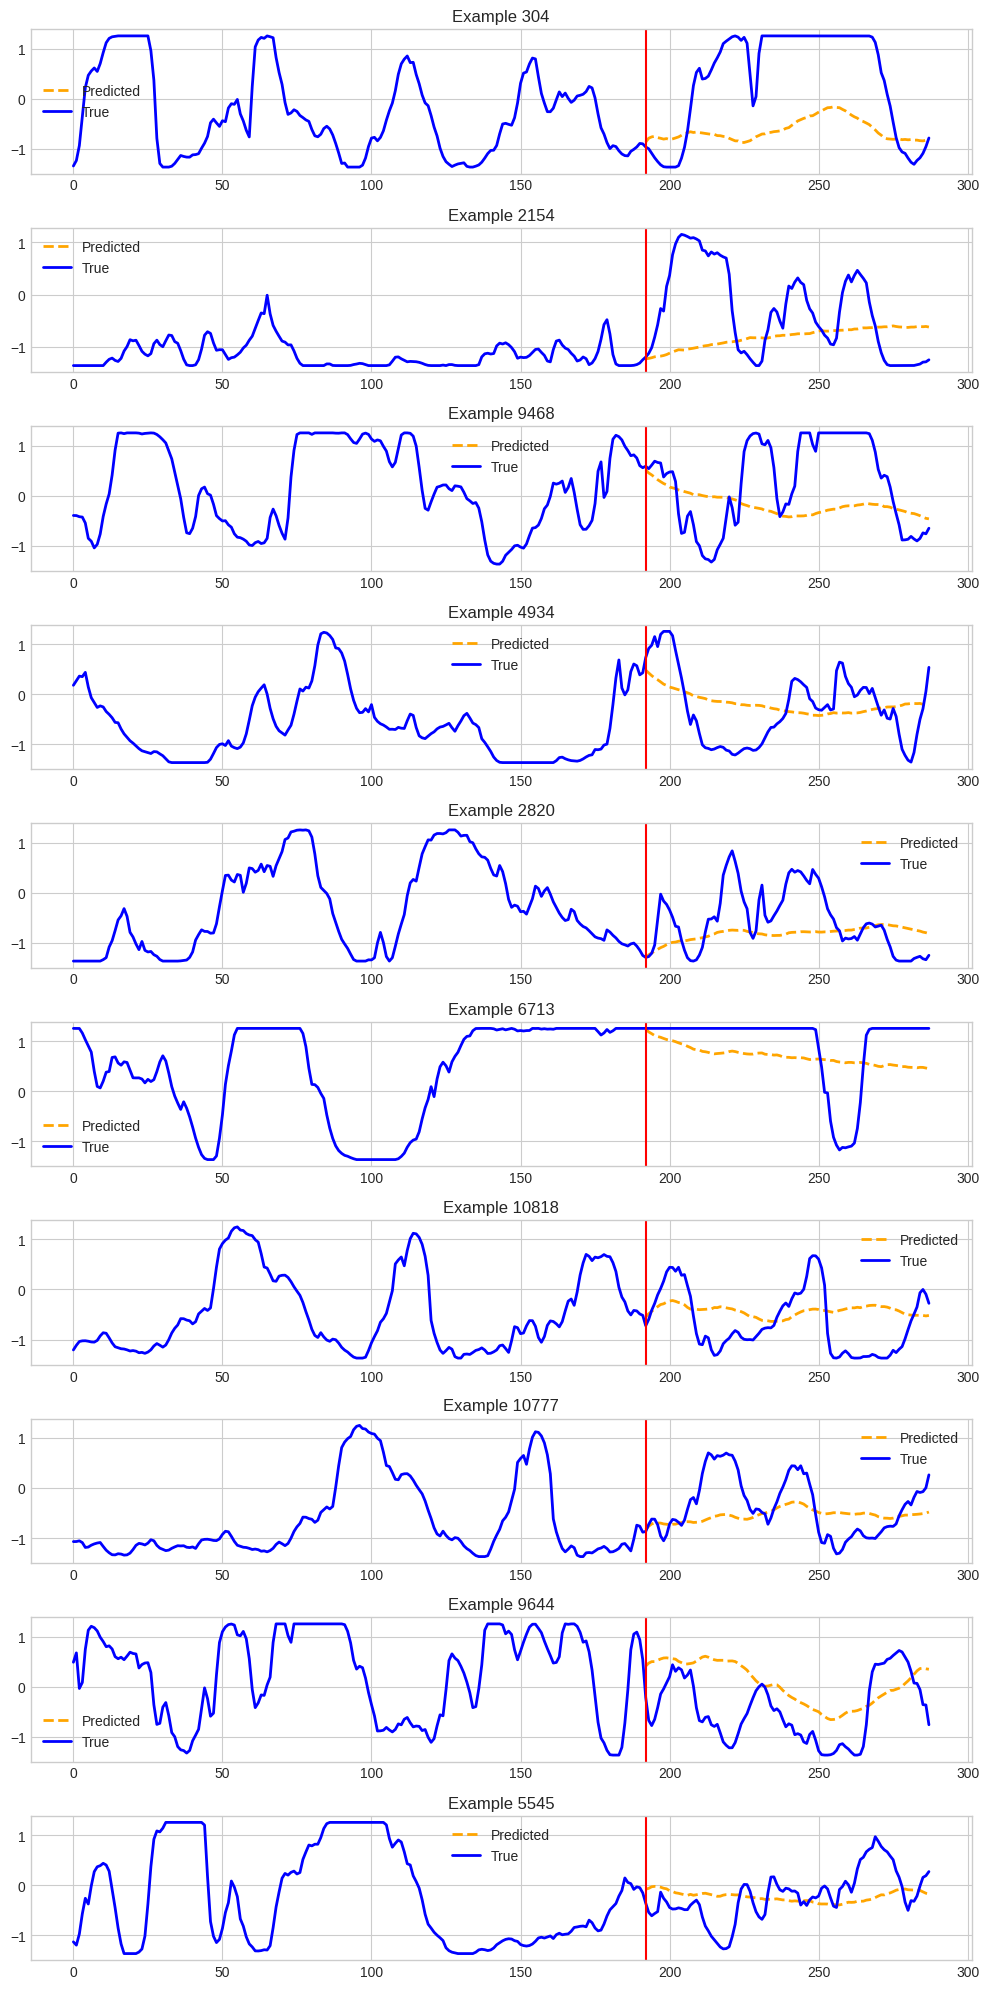

In [26]:
# plot
from tsfm_public.toolkit.visualization import plot_predictions
plot_predictions(
    model=zeroshot_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix="test_zeroshot",
    channel=0,
)

# Few-Shot evaluation model

In [43]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision=TTM_MODEL_REVISION, head_dropout=0.7)
finetune_forecast_model

TinyTimeMixerForPrediction(
  (backbone): TinyTimeMixerModel(
    (encoder): TinyTimeMixerEncoder(
      (patcher): Linear(in_features=64, out_features=192, bias=True)
      (mlp_mixer_encoder): TinyTimeMixerBlock(
        (mixers): ModuleList(
          (0): TinyTimeMixerAdaptivePatchingBlock(
            (mixer_layers): ModuleList(
              (0-1): 2 x TinyTimeMixerLayer(
                (patch_mixer): PatchMixerBlock(
                  (norm): TinyTimeMixerNormLayer(
                    (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
                  )
                  (mlp): TinyTimeMixerMLP(
                    (fc1): Linear(in_features=32, out_features=64, bias=True)
                    (dropout1): Dropout(p=0.2, inplace=False)
                    (fc2): Linear(in_features=64, out_features=32, bias=True)
                    (dropout2): Dropout(p=0.2, inplace=False)
                  )
                  (gating_block): TinyTimeMixerGatedAttention(
              

###Freeze the TTM backbone

In [44]:
print(
        "Number of params before freezing backbone",
        count_parameters(finetune_forecast_model),
    )

# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False

# Count params
print(
    "Number of params after freezing the backbone",
    count_parameters(finetune_forecast_model),
)

Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696


## Fine tune few-shot 5%

In [45]:
# Important parameters
learning_rate = 0.001
num_epochs = 10 # Ideally, we need more epochs (try offline preferably in a gpu for faster computation)
batch_size = 64

In [46]:
print(f"Using learning rate = {learning_rate}")
finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Using learning rate = 0.001


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.757300,0.870613
2,1.122600,0.829524
3,0.813200,0.843054
4,0.772400,0.850917
5,0.756300,0.857336
6,0.752000,0.859397
7,0.739800,0.858135
8,0.736900,0.861055
9,0.735500,0.860160
10,0.732100,0.860120


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: T

[TrackingCallback] Mean Epoch Time = 1.768173599243164 seconds, Total Train Time = 79.25817966461182


TrainOutput(global_step=260, training_loss=0.8918071086590107, metrics={'train_runtime': 79.2646, 'train_samples_per_second': 202.739, 'train_steps_per_second': 3.28, 'total_flos': 397542899712000.0, 'train_loss': 0.8918071086590107, 'epoch': 10.0})

In [47]:
finetune_forecast_trainer.evaluate(test_dataset)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


{'eval_loss': 0.8784336447715759,
 'eval_runtime': 6.973,
 'eval_samples_per_second': 1638.464,
 'eval_steps_per_second': 25.67,
 'epoch': 10.0}

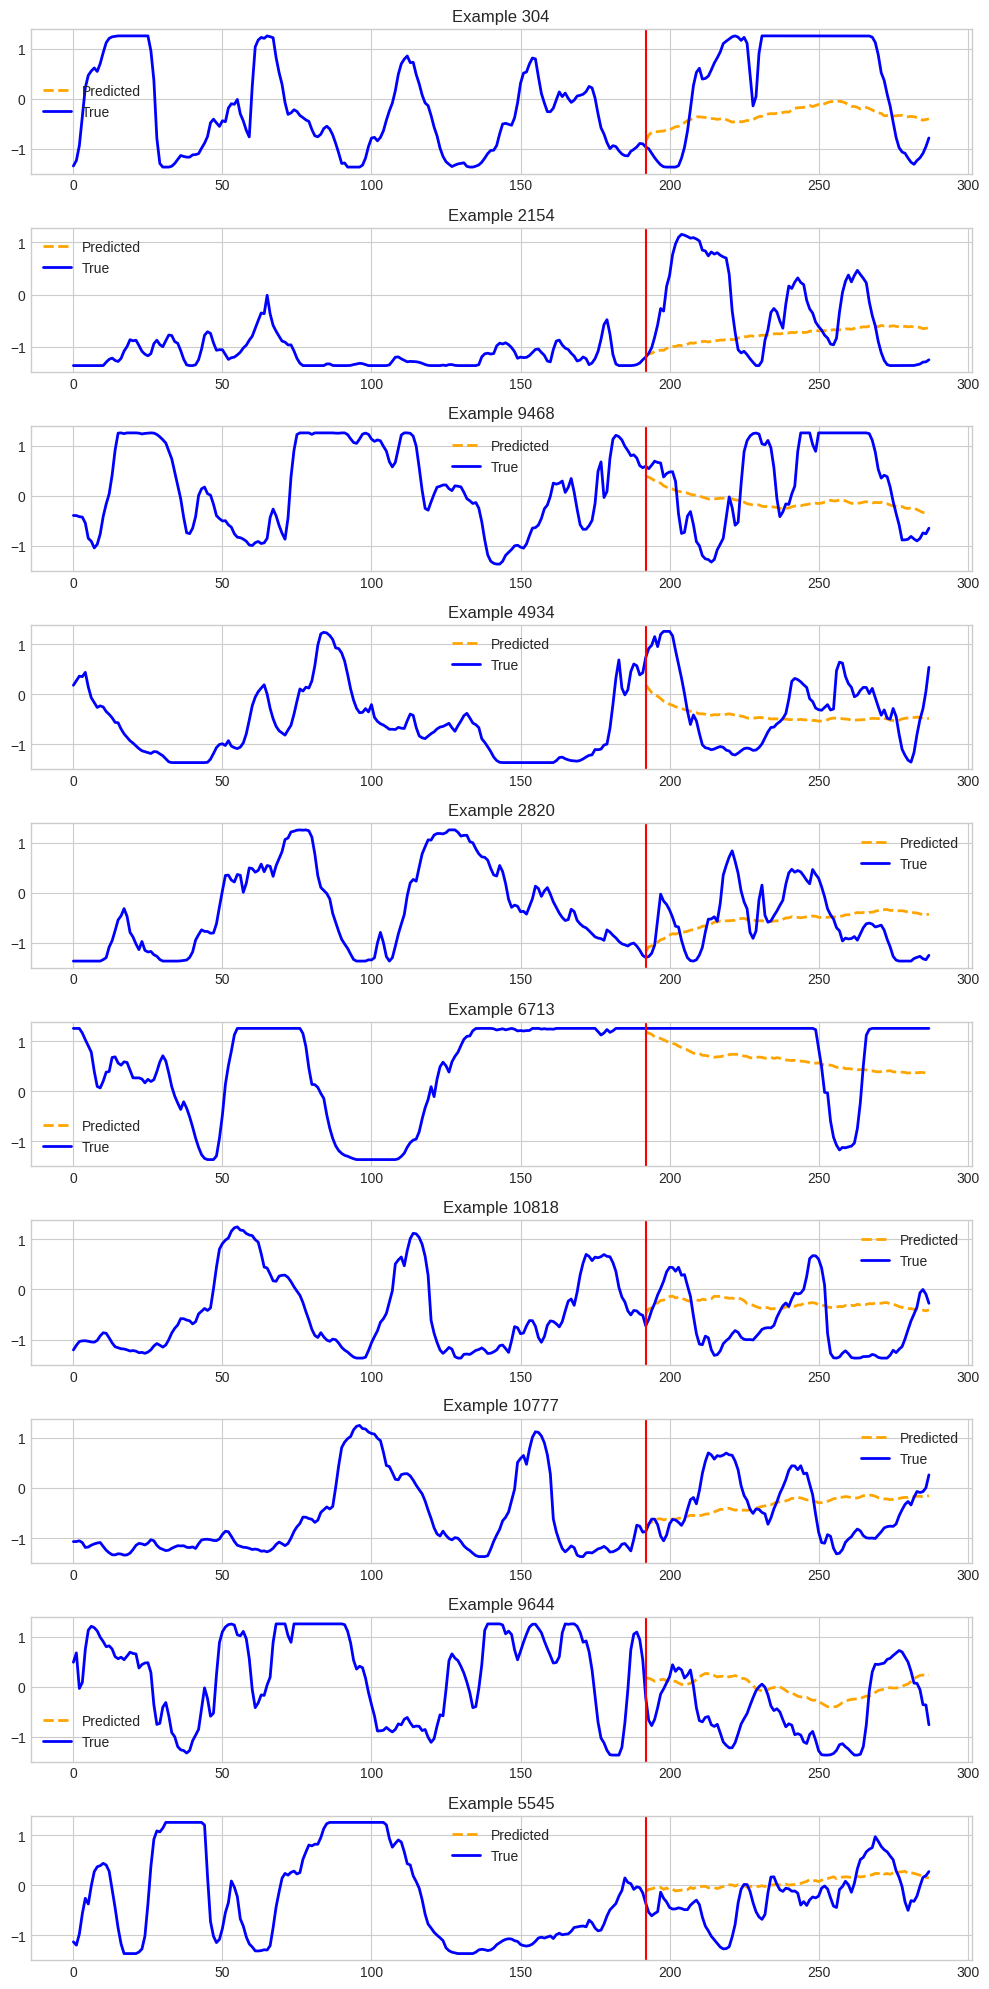

In [48]:
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=test_dataset,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix="test_finetune",
    channel=0,
)

In [52]:
# prompt: Save the few shot model and compress to zip

import zipfile
import os

# Define the directory containing the model files
model_directory = "/content/sample_data/finetuned_ttm_model"

# Define the zip file name
zip_file_name = "few_shot_model.zip"

# Create a zip file
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(model_directory):
        for file in files:
            zipf.write(os.path.join(root, file),
                       os.path.relpath(os.path.join(root, file), model_directory))

print(f"Model saved and compressed to {zip_file_name}")


Model saved and compressed to few_shot_model.zip


In [55]:
# prompt: load model from zip file

import zipfile
import torch
from transformers import Trainer, TrainingArguments

# Define the path to your zip file
zip_file_path = "/content/tsfm/few_shot_model.zip"

# Define the directory to extract the model to
extract_dir = "extracted_model"

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Load the model from the extracted directory
model = TinyTimeMixerForPrediction.from_pretrained(extract_dir) # Assuming TinyTimeMixerForPrediction is defined

# Example usage (assuming you have a test dataset and trainer setup)
# Load the training arguments from the extracted directory or define your own.
# Replace with the path to your saved training arguments if you have them
training_args = TrainingArguments(output_dir="./results")

# Create a trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset
)
# Evaluate the model
trainer.evaluate()


{'eval_loss': 0.8784336447715759,
 'eval_model_preparation_time': 0.0037,
 'eval_runtime': 14.4692,
 'eval_samples_per_second': 789.606,
 'eval_steps_per_second': 98.761}